### <center> Elektrotehnicki fakultet Univerzitet u Beogradu </center> ###

![alt text](grb.jfif "Title")

## <center> Masinsko ucenje </center> ##
# <center>Domaći zadatak - Logistička regresija</center> #

#### <center>Jovana Savic 2020/3423</center> ####

## 1. Postavka problema

### Podaci ###

U datoteci *multiclass_data.csv* su podaci iz obučavajuceg skupa za jedan klasifikacioni problem. Prvih pet kolona predstavljaju vrednosti obeležja, dok je u poslednjoj koloni oznaka klase.

### Zadatak ###

Podatke treba klasifikovati primenom:
- Logističke regresije
- Softmax regresije
- Generativnih algoritama

U fajlu `util.py` se nalazi funkcija koja se koristi za učitavanje i standardizaciju podataka, koja će ujedno i podatke odmah podeliti na obučavajući i testirajući skup.

In [4]:
import util
X_train, X_test, y_train, y_test = util.read_standardize_split_data("multiclass_data.csv")

## 2. Logistička regresija

Logistička funkcija se definiše formulom:

$$ h(x) = \sigma (\theta^Tx) = \frac{1}{1+e^{-\theta^Tx}} $$

Ovom funkcijom definišemo verovatnoću da je izlaz za dato $x$ jednak jedinici. 

Logaritam verodostojnosti za obučavajući skup je tada:

$$ l(\theta) = \sum_{i=1}^m y^{(i)} \log (h(x^{(i)}) +(1-y^{(i)}) \log (1 - h(x^{(i)})) $$

Izvod ove funkcije je:

$$ \frac{\partial l}{\partial \theta}=\sum_{i=1}^m (y^{(i)}-h(x^{(i)}))x^{(i)} $$

Ovo može da se napiše kao:

$$ \frac{\partial l}{\partial \theta}=X^T(y-h(X))=X^T(y-\sigma(X\theta))$$

Korak za gradijent je dat formulom:

$$ \theta := \theta + \alpha \frac{\partial l}{\partial \theta}$$

U ovom slučaju koristimo šaržni gradijentni spust.

U konkretnom problemu imamo više od dve klase i u tom slučaju radimo po principu jedan protiv svih, to jest, radimo logističku regresiju za svaku klasu proglašavajući odbirke ostalih klasa drugom klasom. Na kraju odbirak pridružujemo onoj klasi za koju je verovatnoća najveća.

In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(theta, X, y):
    y_pred = sigmoid(X @ theta)
    return -np.sum(y * np.log(y_pred + 1e-6) + (1-y) * np.log(1-y_pred + 1e-6))

In [9]:
class MyLogisticRegression:
    def __init__(self, X_train, y_train): # TODO: add degree
    
        self.X = X_train.copy()
        self.y = (y_train.copy()).reshape(-1, 1)
        
        self.n = X_train.shape[1] # num of features
        self.m = X_train.shape[0] # num of samples
        
        self.l = max(y_train) + 1 # num of classes
        self.theta = np.random.randn(self.n, self.l)
        
        
    def fit_class(self, l, alpha, max_iterations, eps):
        
        theta = (self.theta[:, l]).reshape(-1,1)
        y = ((self.y == l).astype(int))
        costs = []
        costs.append(cost(theta, self.X, y))
        
        for epoch in range(0, max_iterations):
            
            y_pred = (sigmoid(self.X @ theta)).reshape(-1, 1)
            diff = y - y_pred
            grad = (self.X.T @ diff)
            theta += alpha*grad
            costs.append(cost(theta, self.X, y))
            
            if (abs(costs[-1] - costs[-2]) < eps):
                self.theta[:, l] = np.squeeze(theta).copy()
                return costs
            
        print("Used maximum number of iterations")
        self.theta[:, l] = np.squeeze(theta).copy()
        return costs
    
    def fit(self, alpha, max_iterations, eps):
        costs = []
        for l in range(0, self.l):
            costs.append(self.fit_class(l, alpha, max_iterations, eps))
        
        return costs
    
    def predict(self, X):
        
        h = sigmoid(X @ self.theta)
        y = np.argmax(h, axis=1)
        return y
    
    def reset(self):
        self.theta = np.random.randn(self.n, self.l)

### 2.1. Preciznost klasifikacije i validacija implementacije

In [10]:
from sklearn.metrics import accuracy_score

lr = MyLogisticRegression(X_train, y_train)
costs = lr.fit(alpha=0.1, eps=1e-5, max_iterations=1000)
y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

print("Tacnost na testirajucem skupu: ",
      accuracy_score(y_test, y_test_pred))
print("Tacnost na obucavajucem skupu: ",
      accuracy_score(y_train, y_train_pred))
print("Parametri:")
print(lr.theta.T)

Tacnost na testirajucem skupu:  0.9629629629629629
Tacnost na obucavajucem skupu:  0.9668874172185431
Parametri:
[[ 2.01846711  1.66762069 -0.04504988  0.64905818  4.17480785]
 [-2.86458765  3.08032665 -3.96698091 -0.28380125 -3.90999687]
 [ 0.39079837 -5.91260689  5.83510974  0.99093374 -0.66320168]]


Vidmo da su rezultati na validacionom skupu praktično isti kao i na obučavajućem što govori da model nije preobučen i da ume da klasifikuje i nove podatke. Konačno, možemo da uporedimo greške koje daje naš model sa onim iz biblioteke (bez regularizacije, pošto i ovde nije korišćena).

In [11]:
# Compare with library.
lr = LogisticRegression(penalty='none', 
                        fit_intercept = False,
                        multi_class = 'ovr',
                        max_iter = 1000,
                        tol = 1e-5)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)
print("Tacnost na testirajucem skupu: ",
      accuracy_score(y_test, y_test_pred))
print("Tacnost na obucavajucem skupu: ",
      accuracy_score(y_train, y_train_pred))
print("Parametri: ")
print(lr.coef_)

Tacnost na testirajucem skupu:  0.9629629629629629
Tacnost na obucavajucem skupu:  0.9668874172185431
Parametri: 
[[ 2.0148986   1.66388123 -0.04489733  0.64968185  4.1655802 ]
 [-2.85701835  3.06338783 -3.94817487 -0.2793442  -3.8903992 ]
 [ 0.39549441 -5.95312704  5.86085308  1.00483427 -0.66116536]]


Rezultati se skoro potpuno preklapaju sa rezultatima funkcije iz `sklearn` biblioteke što znači da je implementacija validna.

### 2.2. Promene funkcije gubitka u zavisnosti od parametra učenja

In [12]:
import matplotlib.pyplot as plt

lr = MyLogisticRegression(X_train, y_train)
costs_right = lr.fit(alpha=0.1, eps=1e-5, max_iterations=1000)
lr.reset()
costs_bigger = lr.fit(alpha=0.5, eps=1e-5, max_iterations=1000)
lr.reset()
costs_smaller = lr.fit(alpha=0.0001, eps=1e-5, max_iterations=1000)

Used maximum number of iterations
Used maximum number of iterations
Used maximum number of iterations
Used maximum number of iterations
Used maximum number of iterations
Used maximum number of iterations


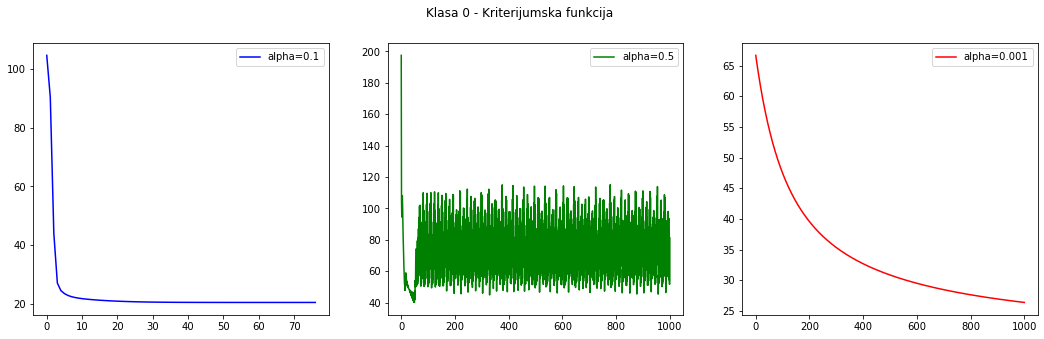

In [13]:
fig = plt.figure(1, figsize=(18, 5))
fig.suptitle('Klasa 0 - Kriterijumska funkcija')
plt.title("Kriterijumska funkcija - klasa 0")
plt.xlabel("iteracija")
plt.ylabel("Kriterijumska funkcija")
plt.subplot(1, 3, 1)
plt.plot(costs_right[0], color="blue", label="alpha=0.1")
plt.legend()
plt.subplot(1,3, 2)
plt.plot(costs_bigger[0], color="green", label="alpha=0.5")
plt.legend()
plt.subplot(1,3,3)
plt.plot(costs_smaller[0], color="red", label="alpha=0.001")
plt.legend()
plt.show()

Skroz levo je prikazan slučaj za izabranu vrednost parametra učenja. Funkcija jako brzo konvergira ka minimumu i sa jako malo iteracija možemo da dobijemo rešenje (čak i to može da se prepolovi ako algoritmu damo veću toleranciju). 

Slika u sredini prikazuje situaciju u kojoj je parametar $\alpha$ preveliki. Na početku se jako brzo stiže do malih vrednosti, ali nakon toga vrednost kriterijumske funkcije osciluje jer je korak preveliki. Veliki korak dovodi do toga da kada je funkcija blizu minimuma, promena koju uvedemo bude prevelika i minimum se preskoči, nakon toga, ponovo idemo u pravcu minimuma sa neke druge strane i ponovo ga preskačemo. Ovo se vidi kao oscilacije na grafiku. Na kraju se algoritam završava jer je premašio broj zadatih iteracija, a ne zato što je zaista došao do minimuma (za šta je i dao upozorenje). 

Na slici desno vidimo kako se algoritam ponaša kada je parametar obučavanja premali. U ovom slučaju se algoritam takođe završio zbog toga što je premašio maksimalan broj iteracija (to vidimo na osnovu upozorenja). Za razliku od prethodnog slučaja, u ovom slučaju bi algoritam došao do minimuma da je imao više iteracija. Očigledno, zbog malog koraka, algoritam jako sporo napreduje. Samo računanje gradijenta nije jeftina operacija kada ima puno podataka, pogotovo kada se koristi šaržni gradijent gde treba uzeti sve podatke, i zato veliki broj iteracija može da bude problem.

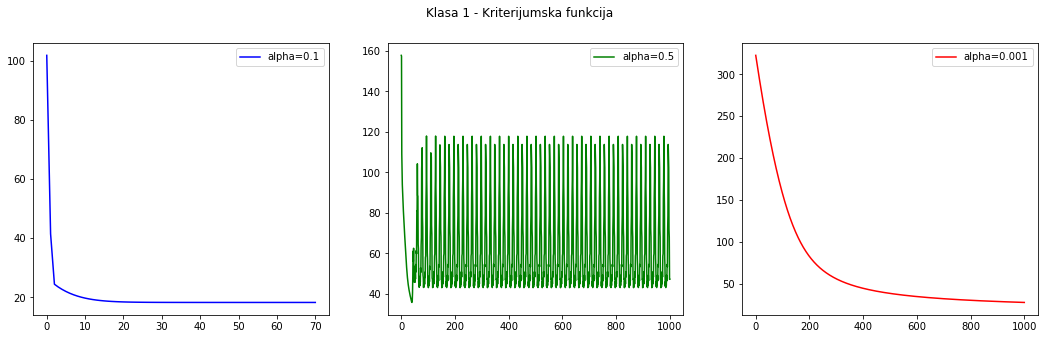

In [14]:
fig = plt.figure(1, figsize=(18, 5))
fig.suptitle('Klasa 1 - Kriterijumska funkcija')
plt.title("Kriterijumska funkcija - klasa 1")
plt.xlabel("iteracija")
plt.ylabel("Kriterijumska funkcija")
plt.subplot(1, 3, 1)
plt.plot(costs_right[1], color="blue", label="alpha=0.1")
plt.legend()
plt.subplot(1,3, 2)
plt.plot(costs_bigger[1], color="green", label="alpha=0.5")
plt.legend()
plt.subplot(1,3,3)
plt.plot(costs_smaller[1], color="red", label="alpha=0.001")
plt.legend()
plt.show()

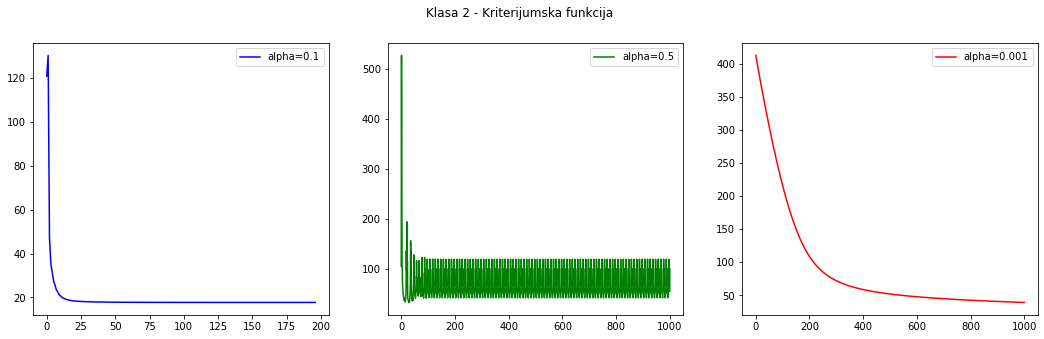

In [15]:
fig = plt.figure(1, figsize=(18, 5))
fig.suptitle('Klasa 2 - Kriterijumska funkcija')
plt.title("Kriterijumska funkcija - klasa 2")
plt.xlabel("iteracija")
plt.ylabel("Kriterijumska funkcija")
plt.subplot(1, 3, 1)
plt.plot(costs_right[2], color="blue", label="alpha=0.1")
plt.legend()
plt.subplot(1,3, 2)
plt.plot(costs_bigger[2], color="green", label="alpha=0.5")
plt.legend()
plt.subplot(1,3,3)
plt.plot(costs_smaller[2], color="red", label="alpha=0.001")
plt.legend()
plt.show()

Kriterijumska funkcija se malo razlikuje u zavisnosti od klase, ali ima slične vrednosti minimuma. Kao što možemo da vidimo sa slika, parametar obučavanja različito utiče na kriterijumske funkcije.

## 3. Softmax regresija

Smatramo da željeni izlaz ima multinomijalnu raspodelu, to jest:

$$ y=\left(\begin{array}{c}1\ 2\ ... \ k\\ \phi_1 \ \phi_2 \ ... \ \phi_k\end{array}\right)$$

gde $\phi_k$ nije nezavisan parametar jer suma verovatnoća treba da bude jednaka jedinici.


Neka je matrica $ \Theta=[\theta_1 \ \theta_2 \ ... \ \theta_k]$ matrica koja transformise odbirak u logite:

$$x^T \Theta=\eta $$

Definišemo softmax transformaciju red-vektora kao:

$$\sigma(\eta) = [\phi_1 \ \phi_2 \ ... \ \phi_k] $$

gde je 

$$\phi_i = \frac{e^{\eta_i}}{\sum_{j=1}^{k}e^{\eta_j}} $$

Deljenje nam omogućava da dobijemo vrednosti za $\phi$ koje su u opsegu između 0 i 1, a očigledno njihov zbir daje jedinicu. Parametar $\theta_k$ nije nezavisan jer ni $\phi_k$ nije nezavisno. Jedna opcija je da postavimo $\theta_k=0$ i računamo gradijent za ostale komponente, i da verovatnoću $\phi_k$ nalazimo oduzimanjem sume ostalih verovatnoća od jedinice. Druga opcija je da dozvolimo da i $\theta_k$ menja vrednosti (što će biti posledica promene drugih verovatnoća, pa samim tim i verovatnoće $\phi_k$, a samim tim i $\theta_k$). Ovaj drugi način omogućava da gradijent i donošenje odluke dosta uprostimo i predstavimo operacijama sa matricama (`numpy` je posebno prilagođena radu sa matricama i na ovaj način mogu da se iskoriste prednosti koje postoje).

Kada je u pitanju donošenje odluke, odluku donosimo tako što odbirak pridružujemo klasi za koju je verovatnoća najveća. Zgodno je što primena softmax transformacije zapravo ne menja poredak u red-vektoru logita, kolona u kojoj je maksimalan logit je takođe ona u kojoj će i verovatnoća biti maksimalna jer je eksponencijalna funkcija strogo rastuća. Prema tome, donošenje odluke može da se donese na osnovu logita, bez računanja softmax transformacije.

Neka je sa $L$ oznacena kriterijumska funkcija koju zelimo da minimizujemo. Nju minimizujemo tako sto menjamo vrednosti parametara $\theta_{ij}$. Prema tome, potrebno je odrediti njen izvod po matrici $\Theta$. 

Ovaj izvod je oblika:

$$ \large \frac{\partial L}{\partial \Theta}=\begin{bmatrix}
    \frac{\partial L}{\partial \theta_{11}} & \frac{\partial L}{\partial \theta_{12}}  & \dots  & \frac{\partial L}{\partial \theta_{1k}} \\
    \vdots & \vdots  & \ddots & \vdots \\
    \frac{\partial L}{\partial \theta_{n1}} & \frac{\partial L}{\partial \theta_{n2}} & \dots  &\frac{\partial L}{\partial \theta_{nk}}
\end{bmatrix}$$

Imamo da je

$$ \frac{\partial L}{\partial \theta_{ij}}=\sum_{k}\frac{\partial L}{\partial \eta_k}\frac{\partial \eta_k}{\partial \theta_{ij}} $$

Kako je $\eta_k=x^T \theta_{:,k}$ parcijalni izvodi po $\theta_{ij}$ su nula za svako $k \neq j$.

Ovim dobijamo:

$$ \frac{\partial L}{\partial \theta_{ij}}=\frac{\partial L}{\partial \eta_j}\frac{\partial \eta_j}{\partial \theta_{ij}}=\frac{\partial L}{\partial \eta_j}x_i$$

gde je $x_i$ $i$-ta komponenta vektora $x$. 

Izvod kriterijumske funkcije po vektoru $\eta$ je:

$$ \frac{\partial L}{\partial \eta}=\left[\frac{\partial L}{\partial \eta_1} \ \dots \frac{\partial L}{\partial \eta_k} \right]$$

pa gornji izvod po matrici $\Theta$ mozemo da upakujemo u:

$$ \frac{\partial L}{\partial \Theta}=x\frac{\partial L}{\partial \eta} $$

Logaritam verodostojnosti za jedan odbirak je dat izrazom:

$$ l(\Theta, x^{(i)}, y^{(i)}) = \log \phi_{y^{(i)}} $$

Ovaj izraz moze da se transformise u:

$$ l(\Theta, x^{(i)}, y^{(i)}) = \eta_{y^{(i)}} - \log \sum_{j=1}^{k} e^{\eta_j} $$

Gradijent kriterijumske funkcije po $\eta_l$ je:

$$ \frac{\partial l}{\partial \eta_l}=\frac{\partial \eta_{y^{(i)}}}{\partial \eta_l}-\frac{1}{\sum_{j=1}^ke^{\eta_j}} \sum_{j=1}^{k}\frac{\partial e^{\eta_j}}{\partial \eta_l} $$

Primetimo da je izvod sa leve strane jednak jedinici ako je $y^{(i)}=l$ , u suportnom nula, dok je sa desne strane nula za sve članove sume osim $j=l$, pa se dobija:

$$ \frac{\partial l}{\partial \eta_l}=1_{y^{(i)}=l}-\frac{e^{\eta_l}}{\sum_{j=1}^ke^{\eta_j}} $$

Ako sa $y^1$ definisemo red-vektor koji ima jedinicu tamo gde je vrednost $y^{(i)}$ i nule na ostalim mestima, tada možemo da nađemo izvod logaritma verodostojnosti po vektoru $\eta$ kao:

$$ \frac{\partial L}{\partial \eta}=y^1-\sigma(\eta) $$

gde smo sa $\sigma$ označili softmax funkciju.

Konačno, možemo da zamenimo vrednost izvoda po $\eta$ u izraz za izvod po $\Theta$ i dobijamo:

$$ \frac{\partial L}{\partial \Theta}=x(y^1-\sigma(\eta))$$

Izvedeni izraz važi za funkciju gubitka na jednom odbirku. Ukupan gubitak je suma gubitaka po svim odbircima: 

 $$ \frac{\partial L}{\partial \Theta}=\sum_{i=1}^{m}x^{(i)}(y^1-\sigma(\eta))^{(i)}$$

Ako definišemo da softmax transformacija može da se primeni na matrici tako što se primenjuje posebno na svaki red i ako umesto vektora $y^1$ koristimo matricu $Y$ u kojoj jedan red odgovara vektoru $y^1$ na odgovarajućem odbirku možemo da pišemo:

$$ \frac{\partial L}{\partial \Theta}=X^T(Y-\sigma(X\Theta))$$

### 3.1. Implementacija

U nastavku je data implementacija softmax regresije gde se koristi gradijentni spust sa mini šaržama za određivanje parametara.

In [50]:
from numpy import linalg as LA

def cost(logits,y):
    
    Y = logits[np.arange(len(logits)),y] 
    cost = - Y + np.log(np.sum(np.exp(logits),axis=1))    
    return np.sum(cost)

def grad_softmax(logits,reference_answers):
    
    Y = np.zeros_like(logits)
    Y[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
#     return (- Y + softmax) / logits.shape[0]
    return (-Y + softmax)
   
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
class mySoftmax:
    def __init__(self, X_train, y_train):
        self.X = X_train.copy()
        self.y = y_train.copy()
        
        self.n = X_train.shape[1] #num of features
        self.m = X_train.shape[0] #num of samples
        self.k = max(y_train) + 1 #num of classes
        
        self.theta = np.random.randn(self.n, self.k)
        self.momentum = np.zeros_like(self.theta)
        
    def predict(self, X_test):
        logits = X_test @ self.theta
        return np.argmax(logits, axis=1)
    
    def fit_theta(self, X_batch, y_batch, alpha):
        old_theta = self.theta.copy()
        logits = X_batch @ self.theta
        dl = grad_softmax(logits, y_batch)
        d_theta = X_batch.T @ dl
#         self.momentum = eta * self.momentum + alpha * d_theta
#         self.theta -= self.momentum
        self.theta -= alpha * d_theta
        
    def fit(self, batch_size, alpha, max_iterations, eps):
        
        costs = []
        logits = self.X @ self.theta
        costs.append(softmax(logits, self.y))
        
        for epoch in range(max_iterations):

            for x_batch,y_batch in iterate_minibatches(
                    self.X,self.y,batchsize=batch_size,shuffle=True):
                
                self.fit_theta(x_batch,y_batch, alpha)
            
                logits = self.X @ self.theta   
                costs.append(cost(logits, self.y))
            if (abs(costs[-1] - costs[-2]) < eps):
                return costs
        
        print("Maximum number of iterations used")
        return costs
    
    def reset(self):
        self.theta = np.random.randn(self.n, self.k)
        self.momentum = np.zeros_like(self.theta)

### 3.2. Preciznost klasifikacije i validnost implementacije

In [72]:
s = mySoftmax(X_train, y_train)
costs = s.fit(batch_size=16, alpha=0.001, eps=1e-6, max_iterations=2000)
y_test_pred = s.predict(X_test)
y_train_pred = s.predict(X_train)

print("Tacnost na testirajucem skupu: ",
      accuracy_score(y_test, y_test_pred))
print("Tacnost na obucavajucem skupu: ",
      accuracy_score(y_train, y_train_pred))
print("Parametri:")
print(s.theta.T)

Tacnost na testirajucem skupu:  1.0
Tacnost na obucavajucem skupu:  0.9801324503311258
Parametri:
[[ 2.36749099  0.73950247  1.33501308  1.65353705  1.5992045 ]
 [-0.14644161  0.67102572 -2.71477988  0.83621786 -2.2164626 ]
 [ 1.54557418 -2.29121135  2.21114618  0.49046495  0.31126735]]


Prikazano rešenje daje jako dobre rezultate na validacionom skupu.

### 3.3. Promene funkcije gubitka u zavisnosti veličine šarža

In [74]:
s = mySoftmax(X_train, y_train)
costs_right = s.fit(batch_size=16, alpha=0.001, eps=1e-4, max_iterations=2000)
s.reset()
costs_bigger = s.fit(batch_size=150, alpha=0.001, eps=1e-4, max_iterations=2000)
s.reset()
costs_smaller = s.fit(batch_size=1, alpha=0.001, eps=1e-4, max_iterations=2000)

Maximum number of iterations used


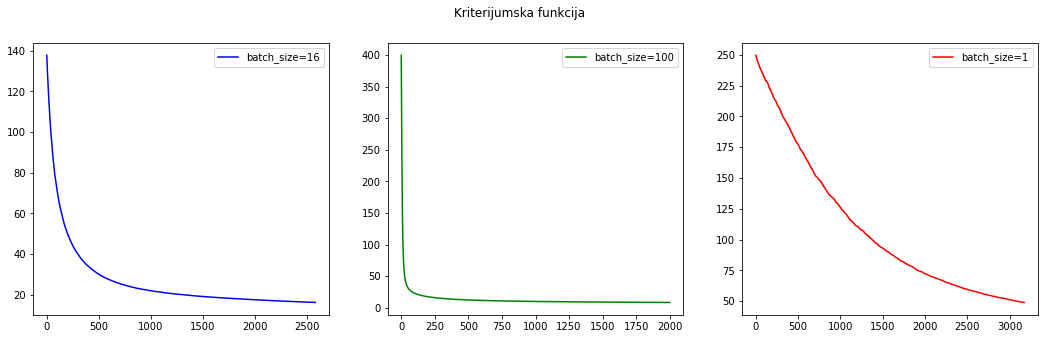

In [76]:
fig = plt.figure(1, figsize=(18, 5))
fig.suptitle('Kriterijumska funkcija')
plt.xlabel("iteracija")
plt.ylabel("Kriterijumska funkcija")
plt.subplot(1, 3, 1)
plt.plot(costs_right, color="blue", label="batch_size=16")
plt.legend()
plt.subplot(1,3, 2)
plt.plot(costs_bigger, color="green", label="batch_size=100")
plt.legend()
plt.subplot(1,3,3)
plt.plot(costs_smaller, color="red", label="batch_size=1")
plt.legend()
plt.show()

Na slici iznad je prikazano kako se kriterijumska funkcija menja nakon svake promene $\Theta$. Zbog toga jedna iteracija nije u svakom slučaju ista. Jedna iteracija sa veličinom 100 i veličinom 16 ili 1 se značajno razlikuju po tome koliko su numerički zahtevne. Prema tome, iako je broj promena parametara najmanji onda kada koristimo skoro sve podatke, svaka od njih traje dosta duže jer su i matrice koje se množe mnogo veće. Svakako, što je veći skup podataka, to je i gradijent veći (obzirom da sabiramo sve vrednosti), pa je i korak koji se pravi veći i kriterijumska funkcija brže opada. Sa druge strane, što je manje podataka korišćeno za računanje gradijenta, to je njegova vrednost manje objektivna (a kako sabiramo gradijent za svaki podatak) i korak je taman manji u tom slučaju. 

Povećavanje parametra `batch_size` značajno povećava ukupan broj prolazaka kroz sve podatke. Tako, kada koristimo 16 odbiraka, prolazimo kroz 40 000 odbiraka, dok u slučaju u kom je veličina 100, prolazimo kroz 200 000 odbiraka, pre nego što dostignemo minimum. 

Funkcija koju minimizujemo ima samo jedan minimum, pa nesigurnost koju unosimo time što ne koristimo sve odbirke za računanje gradijenta ne predstavlja toliki problem, a rezultuje algoritmom koji se mnogo brže izvršava. 

## 3. Gausovska diskriminantna analiza

Gausovska diskriminantna analiza se bazira na tome da se odredi raspodela ulazne promenljive za svaku od klasa kojoj $y$ može da pripada. Pretpostavka je da odbirci imaju normalnu raspodelu. Ako sa $M_l$ i $\Sigma_l$ označimo matematičko očekivanje i kovarijacionu matricu odbiraka koji pripadaju $l$-toj klasi, tada je verovatnoća dobijanja odbirka $x$ tako da on pripada $l$-toj klasi data izrazom:

$$ p(x|y=l) = \frac{1}{(2 \pi)^{n/2} |\Sigma_l|^{1/2}} \exp \left( -\frac{1}{2} (X-M_l)^T \Sigma_l^{-1} (X-M_l)\right) $$

Verovatnoća klase $l$ pod uslovom $x$ je na osnovu Bajesove teoreme proporcionalna:

$$ Pr(l|x) \propto Pr(x|y=l)Pr(y=l) $$

Donošenje odluke podrazumeva pridruživanje odbirka $x$ onoj klasi za koju je gornja verovatnoća maksimalna.

### 3.1. Implementacija

In [77]:
from math import pi

def NormalDistribution(x, M, Sigma):
    n = M.shape[0]
    p = 1 / (((2 * pi) ** n) * (np.linalg.det(Sigma) ** 0.5))
    p *= np.exp(-0.5 * ((x-M).T @ np.linalg.inv(Sigma + 1e-6) @ (x-M)))
    return p
    
class myQDA:
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        
        self.n = X_train.shape[1] # num of features
        self.m = X_train.shape[0] # num of samples
        
        self.l = max(y_train) + 1 # num of classes
        self.M = []
        self.Sigma = []
        self.prob = []
        
    def fit(self):
        
        for i in range(self.l):
            self.M.append(np.mean(self.X[self.y==i, :], axis=0).T)
            self.Sigma.append(np.cov(self.X[self.y==i, :].T))
            self.prob.append(np.count_nonzero(self.y==i) / self.m)
            
    def predict(self, X_test):
        
        probabilities = np.zeros((X_test.shape[0], self.l))
        for i in range(X_test.shape[0]):
            for j in range(self.l):
                probabilities[i, j] = NormalDistribution(X_test[i].T, self.M[j], self.Sigma[j]) * self.prob[j]
        
        y_pred = np.argmax(probabilities, axis=1)
        return y_pred

### 3.2. Preciznost i validnost implementacije

In [78]:
qda = myQDA(X_train, y_train)
qda.fit()
y_pred = qda.predict(X_test)
print('Tačnost na testirajucem skupu: ',
      accuracy_score(y_pred, y_test))

Tačnost na testirajucem skupu:  0.9629629629629629


In [79]:
# Compare with library function.

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)
y_pred = qda.predict(X_test)
print('Tačnost na testirajucem skupu: ',
      accuracy_score(y_pred, y_test))

Tačnost na testirajucem skupu:  0.9629629629629629


Rezultati su isti kao u biblioteci, prema tome, implementacija je validna. Dato rešenje daje dobre rezultate na testirajućem skupu.

## 4. Naivni Bajesov klasifikator

Naivni Bajesov klasifikator je jako sličan Gausovskoj diskriminantnoj analizi kada imamo kontinulane ulaze, razlika je u tome što u ovom slučaju smatramo da su komponente međusobno nezavisne. Za svaku komponentu i klasu određujemo raspodelu i verovatnoća klase $l$ pod uslovom $x$ je proporcionalna:

$$ Pr(l|X) \propto Pr(x_1|y=l)Pr(x_2|y=l) \dots Pr(x_n|y=l)Pr(y=l) $$

### 4.1. Implementacija

In [80]:
def Norm(x, m, sigma):
    return 1 / (sigma * (2 * pi) ** 0.5) * np.exp(-0.5 * ((x-m)/sigma) ** 2)
    
class myBayesNaive:
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        
        self.n = X_train.shape[1] # num of features
        self.m = X_train.shape[0] # num of samples
        
        self.l = max(y_train) + 1 # num of classes
        self.M = np.zeros((self.n, self.l))
        self.Sigma = np.zeros((self.n, self.l))
        self.prob = np.zeros((self.l,1))
        
    def fit(self):
        
        for i in range(self.n):
            for j in range(self.l):
                self.M[i, j] = np.mean(self.X[self.y==j, i])
                self.Sigma[i, j]=np.std(self.X[self.y==j, i])
        
        for i in range(self.l):
            self.prob[i] = np.count_nonzero(self.y==i) / self.m
            
    def predict(self, X_test):
        
        probabilities = np.zeros((X_test.shape[0], self.l))
        for i in range(X_test.shape[0]):
            for j in range(self.l):
                probabilities[i, j] = self.prob[j]
                for k in range(self.n):
                    probabilities[i, j] *= Norm(X_test[i, k], self.M[k, j], self.Sigma[k, j])
        
        y_pred = np.argmax(probabilities, axis=1)
        return y_pred

### 3.2. Preciznost i validnost implementacije

In [81]:
b = myBayesNaive(X_train, y_train)
b.fit()
y_pred = b.predict(X_test)
print('Tačnost na testirajucem skupu: ',
      accuracy_score(y_pred, y_test))

Tačnost na testirajucem skupu:  1.0


In [82]:
# Compare with library
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)

y_pred = gnb.predict(X_test)
print('Tačnost na testirajućem skupu: ',
      accuracy_score(y_pred, y_test))

Tačnost na testirajućem skupu:  1.0


Implementacija je validna. Vidimo da ovaj model daje malo bolju tačnost na testirajućem skupu nego prethodni.

## 5. Zaključak

Dobijene tačnosti na testirajućim skupovima su jako slične, a u nekim slučajevima i iste. Doduše, treba imati u vidu da valdiacioni skup nema mnogo odbiraka, pa činjenica da neki model ima malo manju tačnost ne mora nužno da znači da je zaista gori. Svakako, svaki od prikazanih alata je dao zadovoljavajuće rezultate na testirajućem skupu. 

Ukoliko je potrebno odlučiti se za konkretan model, Gausovska diskriminantna analiza deluje kao najbolja opcija zbog toga što nije potrebno podešavati nikakve hiper-parametre. 